In [60]:
%pip install -q -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  You can safely remove it manually.
  You can safely remove it manually.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location

In [63]:
from utils import prepare_data, TimeMoEPredictor, ChronosPredictor, LLM, wape, ProphetForecast

train, test = prepare_data(sample_size=1000,series_cutoff=12*3,min_series_length=12*3)

train = pd.read_csv("train.csv",parse_dates=['ds'])
test = pd.read_csv("test.csv",parse_dates=['ds'])

c:\Users\janli\m4_tests\utils.py:52: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  .assign(StartingDate = lambda x : pd.to_datetime(x["StartingDate"]))
c:\Users\janli\m4_tests\utils.py:73: FutureWarning: The provided callable <built-in function max> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  df["max"] = df.groupby("unique_id")["row"].transform(max)


The parameters:  [Parameter containing:
tensor([[ 0.1471,  0.1597, -0.0451,  ..., -0.1519, -0.0887, -0.0543],
        [-0.1157,  0.0182, -0.1901,  ..., -0.0744, -0.1476,  0.1579],
        [ 0.0554,  0.0797,  0.0609,  ...,  0.0689,  0.1599, -0.0994],
        ...,
        [-0.1489,  0.0282, -0.1691,  ...,  0.0666, -0.1153,  0.0913],
        [ 0.1050,  0.1181,  0.0503,  ..., -0.0313, -0.0601, -0.1264],
        [ 0.0822,  0.1886, -0.0932,  ...,  0.1234,  0.1290, -0.1314]],
       requires_grad=True), Parameter containing:
tensor([ 0.0367, -0.1020, -0.0893,  0.1660,  0.0930, -0.0526,  0.0283,  0.0373,
         0.0451, -0.0659, -0.1133,  0.1274,  0.0259,  0.0805, -0.0729,  0.0932,
         0.1401,  0.1170,  0.0523,  0.1893, -0.0004,  0.0410,  0.1829,  0.1870,
        -0.0813,  0.1734,  0.0710, -0.0215,  0.1680, -0.0997,  0.1250,  0.1907,
        -0.1327, -0.1136, -0.1907, -0.0346, -0.1748, -0.0645,  0.0584,  0.1360,
         0.1072,  0.1068,  0.0798, -0.1194, -0.1528,  0.0080,  0.1827,  0.01

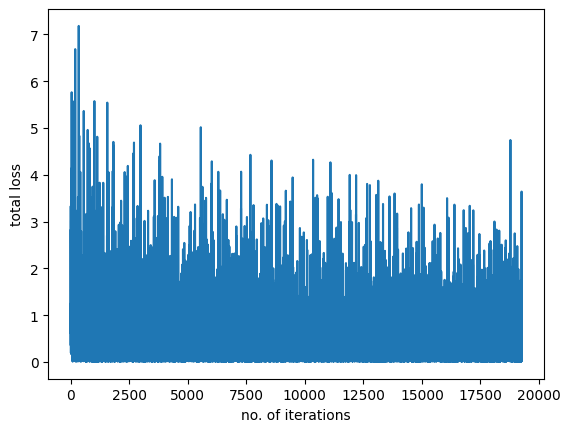

In [80]:
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from sklearn.preprocessing import StandardScaler

torch.manual_seed(42)

# Load M4 dataset (adjust path to where your dataset is)
df = pd.read_csv('train.csv')  # Ensure it has columns 'unique_id', 'ds', 'y'

# Preprocess data: You might need to convert dates and handle missing data
#df['ds'] = pd.to_datetime(df['ds'])
#df = df.sort_values(['unique_id', 'ds'])

# You can scale the y-values for better training

df['y_scaled'] = df.groupby('unique_id')['y'].transform(lambda x: (x - x.mean()) / x.std())

df = df.sort_values(by=["unique_id","ds"])

id_stats = df.groupby('unique_id')['y'].agg(['mean', 'std'])

# Creating the dataset class for multi-target regression
class M4Dataset(Dataset):
    def __init__(self, data, sequence_length=27, target_length=3):
        """
        data: DataFrame with columns ['unique_id', 'ds', 'y']
        sequence_length: Number of previous time steps to consider for prediction
        target_length: Number of future time steps to predict
        """
        self.data = data
        self.sequence_length = sequence_length
        self.target_length = target_length
        self.unique_ids = data['unique_id'].unique()
        
    def __getitem__(self, idx):
        # Select a random unique_id for this batch
        unique_id = self.unique_ids[idx]
        data_by_id = self.data[self.data['unique_id'] == unique_id]

        # We need to take the last `sequence_length` data points for X
        X = data_by_id['y_scaled'].values[-(self.sequence_length+self.target_length):-self.target_length]
        
        # The next `target_length` values are the targets
        y = data_by_id['y_scaled'].values[-self.target_length:]

        # Convert to tensors
        X_tensor = torch.tensor(X, dtype=torch.float32).unsqueeze(0)  # Shape (1, sequence_length)
        y_tensor = torch.tensor(y, dtype=torch.float32).unsqueeze(0)  # Shape (1, target_length)
        
        return X_tensor, y_tensor

    def __len__(self):
        return len(self.unique_ids)

# Creating dataset object for multi-target regression
sequence_length = 27  # Use 12 time steps to predict the next 3 values
target_length = 3  # We want to predict the next 3 time steps
dataset = M4Dataset(df, sequence_length=sequence_length, target_length=target_length)

class LSTMModel(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=1):
        super(LSTMModel, self).__init__()
        
        # Define LSTM layer
        self.lstm = torch.nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = torch.nn.Linear(hidden_dim, output_dim)  # Fully connected layer after LSTM
        
    def forward(self, x):
        # x shape: (batch_size, sequence_length, input_dim)
        lstm_out, _ = self.lstm(x)
        # Get the output from the last time step
        last_time_step = lstm_out[:, -1, :]
        y_pred = self.fc(last_time_step)  # Output layer
        return y_pred

class MultipleLinearRegression(torch.nn.Module):
    # Constructor
    def __init__(self, input_dim, output_dim, dropout_prob=0.5):
        super(MultipleLinearRegression, self).__init__()
        
        # Define the layers
        self.linear1 = torch.nn.Linear(input_dim, 64)  # First hidden layer
        self.relu1 = torch.nn.ReLU()  # Activation function after first hidden layer
        self.dropout = torch.nn.Dropout(dropout_prob)  # Dropout layer
        self.linear2 = torch.nn.Linear(64, 32)  # Second hidden layer
        self.relu2 = torch.nn.ReLU()  # Activation function after second hidden layer
        self.linear3 = torch.nn.Linear(32, output_dim)  # Output layer

    # Prediction
    def forward(self, x):
        x = self.relu1(self.linear1(x))  # Apply ReLU activation after first linear layer
        x = self.dropout(x)  # Apply dropout after first hidden layer
        x = self.relu2(self.linear2(x))  # Apply ReLU activation after second hidden layer
        x = self.linear3(x)  # Output layer (no activation for regression)
        return x

# Model setup
MLR_model = MultipleLinearRegression(sequence_length, target_length)
print("The parameters: ", list(MLR_model.parameters()))

# Defining the model optimizer and loss function
optimizer = torch.optim.Adam(MLR_model.parameters(), lr=0.001)
criterion = torch.nn.MSELoss()

# Create the DataLoader
train_loader = DataLoader(dataset=dataset, batch_size=1, shuffle=True)

# Train the model
losses = []
epochs = 20
for epoch in range(epochs):
    for x, y in train_loader:
        y_pred = MLR_model(x)
        loss = criterion(y_pred, y)
        losses.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"epoch = {epoch}, loss = {loss.item()}")
print("Done training!")

# Plot the losses
plt.plot(losses)
plt.xlabel("no. of iterations")
plt.ylabel("total loss")
plt.show()

The parameters:  [Parameter containing:
tensor([[ 0.0956],
        [ 0.1038],
        [-0.0293],
        [ 0.1148],
        [-0.0274],
        [ 0.0252],
        [-0.0609],
        [ 0.0734],
        [ 0.1102],
        [-0.0917],
        [ 0.1086],
        [ 0.0234],
        [ 0.0924],
        [ 0.0169],
        [ 0.0603],
        [-0.0176],
        [ 0.0964],
        [ 0.0185],
        [-0.0584],
        [ 0.0319],
        [-0.0576],
        [-0.0147],
        [-0.0508],
        [ 0.0829],
        [-0.0987],
        [-0.0576],
        [-0.0353],
        [-0.0752],
        [ 0.0118],
        [-0.1235],
        [ 0.1129],
        [-0.1062],
        [ 0.0965],
        [ 0.0208],
        [-0.0406],
        [ 0.0772],
        [ 0.0195],
        [ 0.1010],
        [ 0.0137],
        [-0.0394],
        [ 0.0336],
        [-0.0339],
        [ 0.0526],
        [ 0.1116],
        [ 0.0723],
        [-0.0546],
        [ 0.0722],
        [ 0.0224],
        [ 0.0635],
        [-0.0762],
        [-

c:\Users\janli\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\loss.py:610: UserWarning: Using a target size (torch.Size([1, 1, 3])) that is different to the input size (torch.Size([1, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1/3, Loss: 0.3999199867248535
Epoch 2/3, Loss: 0.2836325466632843
Epoch 3/3, Loss: 0.2588682770729065
Training complete!


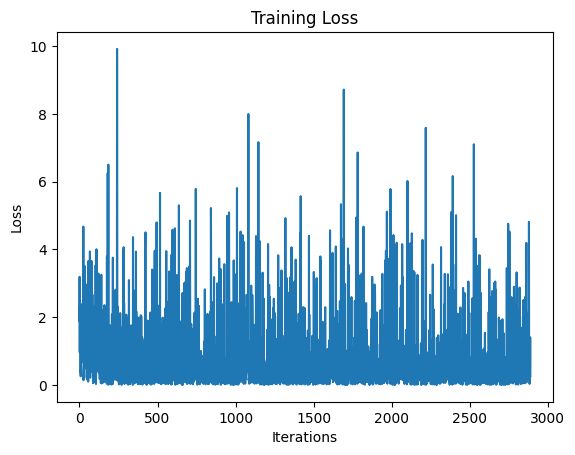

RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

In [ ]:
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from sklearn.preprocessing import StandardScaler

torch.manual_seed(42)

# Load M4 dataset (adjust path to where your dataset is)
df = pd.read_csv('train.csv')  # Ensure it has columns 'unique_id', 'ds', 'y'

# Preprocess data: Scaling the y-values per unique_id
df['y_scaled'] = df.groupby('unique_id')['y'].transform(lambda x: (x - x.mean()) / x.std())

# Calculate statistics for inverse transformation
id_stats = df.groupby('unique_id')['y'].agg(['mean', 'std'])

# Creating the dataset class for multi-target regression
class M4Dataset(Dataset):
    def __init__(self, data, sequence_length=27, target_length=3):
        self.data = data
        self.sequence_length = sequence_length
        self.target_length = target_length
        self.unique_ids = data['unique_id'].unique()

    def __getitem__(self, idx):
        unique_id = self.unique_ids[idx]
        data_by_id = self.data[self.data['unique_id'] == unique_id]

        # Get the input sequence for the LSTM (last `sequence_length` time steps)
        X = data_by_id['y_scaled'].values[-(self.sequence_length + self.target_length):-self.target_length]
        y = data_by_id['y_scaled'].values[-self.target_length:]

        # Reshape X to be (sequence_length, 1), adding the input dimension
        X_tensor = torch.tensor(X, dtype=torch.float32).unsqueeze(-1)  # Shape (sequence_length, 1)
        y_tensor = torch.tensor(y, dtype=torch.float32).unsqueeze(0)  # Shape (1, target_length)

        return X_tensor, y_tensor

    def __len__(self):
        return len(self.unique_ids)


# LSTM model definition (no changes needed here, as input_dim=1)
class LSTMModel(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=1):
        super(LSTMModel, self).__init__()

        # Define LSTM layer
        self.lstm = torch.nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = torch.nn.Linear(hidden_dim, output_dim)  # Fully connected layer after LSTM

    def forward(self, x):
        # x shape: (batch_size, sequence_length, input_dim)
        lstm_out, _ = self.lstm(x)
        
        # If lstm_out has 3 dimensions: (batch_size, sequence_length, hidden_dim)
        if lstm_out.dim() == 3:
            last_time_step = lstm_out[:, -1, :]  # Last time step
        else:
            last_time_step = lstm_out  # Directly use lstm_out (assumed shape: (batch_size, hidden_dim))

        y_pred = self.fc(last_time_step)  # Output layer
        return y_pred


# Hyperparameters for LSTM
input_dim = 1  # Only 1 feature per time step (y_scaled)
hidden_dim = 64  # Number of hidden units in the LSTM
output_dim = 3  # Predict the next 3 time steps
num_layers = 1  # Number of LSTM layers

# Create dataset and dataloaders
sequence_length = 27  # Use 27 time steps to predict the next 3 values
target_length = 3  # We want to predict the next 3 time steps
dataset = M4Dataset(df, sequence_length=sequence_length, target_length=target_length)
train_loader = DataLoader(dataset=dataset, batch_size=1, shuffle=True)

# Initialize the LSTM model
model = LSTMModel(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
print("The parameters: ", list(model.parameters()))

# Optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.MSELoss()

# Training loop
losses = []
epochs = 3
for epoch in range(epochs):
    for x, y in train_loader:
        y_pred = model(x)  # Forward pass
        loss = criterion(y_pred, y)  # Compute loss
        losses.append(loss.item())
        optimizer.zero_grad()  # Zero the gradients
        loss.backward()  # Backpropagation
        optimizer.step()  # Update the model parameters

    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item()}")

print("Training complete!")

# Plotting the loss over epochs
plt.plot(losses)
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.show()

# Inverse transform the predictions and actual values to original scale
def inverse_transform(predictions, unique_ids, id_stats):
    inv_predictions = []
    for i, unique_id in enumerate(unique_ids):
        mean = id_stats.loc[unique_id, 'mean']
        std = id_stats.loc[unique_id, 'std']
        inv_predictions.append(predictions[i] * std + mean)
    return np.array(inv_predictions)

# Example of inverse transforming some predictions (after training)
y_pred_example = model(dataset[0][0])  # Make prediction for the first sample

y_pred_original = inverse_transform(y_pred_example.squeeze().cpu().numpy(), [dataset.unique_ids[0]], id_stats)
print("Predicted values (original scale):", y_pred_original)


In [105]:
import numpy as np

# Initialize a dictionary to store RMSE values per unique_id
rmse_per_group = {}

model.eval()  # Set the model to evaluation mode

with torch.no_grad():  # No gradients needed for inference
    # Iterate over all unique_ids
    for idx in range(len(dataset)):
        # Get the input features for the current sample
        x_input = dataset[idx][0]  # Shape (1, sequence_length, input_dim)

        # Make prediction for the current sample
        y_pred_example = model(x_input)  # Shape (1, target_length)
        
        # Inverse transform the predicted values to the original scale
        unique_id = dataset.unique_ids[idx]
        y_pred_original = inverse_transform(
            y_pred_example.squeeze().cpu().numpy().reshape(-1, 1), 
            [unique_id], 
            id_stats
        )
        
        # Get the actual values (ground truth)
        y_actual = dataset[idx][1].squeeze().cpu().numpy().reshape(-1, 1)
        y_actual_original = inverse_transform(y_actual, [unique_id], id_stats)
        
        # Calculate squared error for each sample
        squared_error = (y_pred_original - y_actual_original) ** 2
        
        # If the unique_id is not in the dictionary, initialize its values
        if unique_id not in rmse_per_group:
            rmse_per_group[unique_id] = {
                "total_squared_error": 0,
                "total_samples": 0
            }

        # Add the squared error to the corresponding unique_id's total squared error
        rmse_per_group[unique_id]["total_squared_error"] += squared_error.sum()
        rmse_per_group[unique_id]["total_samples"] += y_actual_original.size  # Total number of elements in the target tensor

rmses = []
# Calculate RMSE for each group
for unique_id, stats in rmse_per_group.items():
    rmse = np.sqrt(stats["total_squared_error"] / stats["total_samples"])
    rmse_per_group[unique_id]["rmse"] = rmse
    print(f"RMSE for unique_id {unique_id}: {rmse}")
    rmses.append(rmse)


RMSE for unique_id M10010: 280.29515808098336
RMSE for unique_id M10055: 117.49653785398027
RMSE for unique_id M10060: 119.9789001159404
RMSE for unique_id M10085: 71.57702032456746
RMSE for unique_id M10110: 74.83480129744976
RMSE for unique_id M1019: 76.94791568769847
RMSE for unique_id M10305: 741.9520910230535
RMSE for unique_id M10387: 145.81996407027054
RMSE for unique_id M10439: 84.94394928907252
RMSE for unique_id M10524: 1487.8498179662383
RMSE for unique_id M10537: 82.73738520149891
RMSE for unique_id M10554: 711.8238549021971
RMSE for unique_id M10707: 22.446099220464703
RMSE for unique_id M1072: 134.69338628173568
RMSE for unique_id M10748: 382.4999100122591
RMSE for unique_id M10767: 75.18069623610882
RMSE for unique_id M10829: 24.855904209446635
RMSE for unique_id M10833: 16.087292426334898
RMSE for unique_id M1087: 309.42628663522646
RMSE for unique_id M10880: 135.1402165469067
RMSE for unique_id M10940: 305.97607644562777
RMSE for unique_id M10979: 162.67510843034393
RM

In [112]:
pd.Series(rmses).describe()

count      963.000000
mean       786.701593
std       1220.471206
min          1.268062
25%        110.474657
50%        367.476917
75%        917.767285
max      10771.196565
dtype: float64

In [81]:
# Function to inverse transform the predictions back to the original scale
def inverse_transform(predictions, unique_ids, id_stats):
    # Inverse transform for each `unique_id`
    inv_predictions = []
    for i, unique_id in enumerate(unique_ids):
        mean = id_stats.loc[unique_id, 'mean']
        std = id_stats.loc[unique_id, 'std']
        
        # Inverse transformation: y_original = y_scaled * std + mean
        inv_predictions.append(predictions[i] * std + mean)
        
    return inv_predictions


In [82]:
import torch
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader
from sklearn.preprocessing import StandardScaler

# Load your datasets
df = pd.read_csv('train.csv')  # Ensure it has columns 'unique_id', 'ds', 'y'
test = pd.read_csv('test.csv')  # Ensure it has columns 'unique_id', 'ds', 'y'

# Assuming you have the test data as `df_test`
df['y_scaled'] = df.groupby('unique_id')['y'].transform(
    lambda x: (x - id_stats.loc[x.name, 'mean']) / id_stats.loc[x.name, 'std']
)

test['y_scaled'] = test.groupby('unique_id')['y'].transform(
    lambda x: (x - id_stats.loc[x.name, 'mean']) / id_stats.loc[x.name, 'std']
)

ids = test["unique_id"].unique()
# Combine the train and test data for model evaluation
data = pd.concat([df, test])

# Sort and select the last 15 rows for evaluation (ensure there's enough history for predictions)
data = data.sort_values(by=["unique_id", "ds"]).groupby("unique_id").tail(30)

# Dataset and sequence parameters
sequence_length = 27  # Use 12 time steps to predict the next 3 values
target_length = 3  # We want to predict the next 3 time steps
dataset = M4Dataset(data, sequence_length=sequence_length, target_length=target_length)



In [83]:
def inverse_transform(predictions, unique_ids, id_stats):
    inv_predictions = []
    for i, unique_id in enumerate(unique_ids):
        mean = id_stats.loc[unique_id, 'mean']
        std = id_stats.loc[unique_id, 'std']
        inv_predictions.append(predictions[i] * std + mean)
    return np.array(inv_predictions)


In [84]:
import torch
import numpy as np

# RMSE calculation function per group
def calculate_rmse_per_group(model, dataset, id_stats):
    model.eval()  # Set the model to evaluation mode
    
    rmse_per_group = {}

    # Iterate over each group (unique_id)
    for i, unique_id in enumerate(dataset.unique_ids):
        # Get the data for the current group (unique_id)
        group_data = dataset[i]  # Find samples for the current unique_id

        total_squared_error = 0
        total_samples = 0

        # Calculate RMSE for the current group
        with torch.no_grad():
            # Get the model's prediction (output from the model)
            y_pred = model(group_data[0][0])  # Shape (1, target_length)

            # Inverse transform the predictions and actual values to original scale
            y_pred_original = inverse_transform(y_pred.squeeze().cpu().numpy(), [unique_id], id_stats)
            y_original = inverse_transform(group_data[1][0].squeeze().cpu().numpy(), [unique_id], id_stats)

            # Calculate squared error for each prediction on the original scale
            squared_error = (y_pred_original - y_original) ** 2
            total_squared_error += squared_error.sum()  # Sum of squared errors
            total_samples += y_original.shape[0]  # Number of samples (e.g., 3 for target_length)

        # Calculate RMSE for the current group
        rmse = np.sqrt(total_squared_error / total_samples)  # RMSE = sqrt(MSE)
        rmse_per_group[unique_id] = rmse

    return rmse_per_group

# Example: Calculate RMSE per group
rmse_per_group = calculate_rmse_per_group(MLR_model, dataset, id_stats)

# Print RMSE per group
print(rmse_per_group)


{'M10010': np.float64(313.6794740464079), 'M10055': np.float64(90.44514109853276), 'M10060': np.float64(95.33515396583539), 'M10085': np.float64(381.8664071210269), 'M10110': np.float64(11.78529738405814), 'M1019': np.float64(74.93598887961298), 'M10305': np.float64(502.62155482354956), 'M10387': np.float64(223.67121759802967), 'M10439': np.float64(54.461215929684386), 'M10524': np.float64(296.52893018949544), 'M10537': np.float64(101.44960447489166), 'M10554': np.float64(610.6676400526567), 'M10707': np.float64(16.058886188827955), 'M1072': np.float64(23.23896166145687), 'M10748': np.float64(149.93845761118064), 'M10767': np.float64(71.27238804354806), 'M10829': np.float64(15.967128523723886), 'M10833': np.float64(30.459058654868386), 'M1087': np.float64(303.3587709387939), 'M10880': np.float64(135.51869998718894), 'M10940': np.float64(369.39697732949026), 'M10979': np.float64(102.40905141717099), 'M110': np.float64(426.6805456642021), 'M11010': np.float64(699.5201095281209), 'M11056'

In [85]:
data = pd.DataFrame(list(rmse_per_group.items()), columns=['unique_id', 'value'])


In [86]:
data["value"].describe()

count      963.000000
mean       587.359185
std        970.863766
min          0.227035
25%         83.957919
50%        283.500494
75%        688.928633
max      13686.625434
Name: value, dtype: float64

In [87]:
test = df.groupby("unique_id").tail(3)
test = test.merge(df.groupby("unique_id").tail(4).groupby("unique_id").head(1).rename(columns={"y":"lag"})[["unique_id","lag"]],on=["unique_id"])

In [88]:
(np.sqrt( (test["lag"]-test["y"])**2) ).describe()

count     2889.000000
mean       401.866570
std        865.920868
min          0.000000
25%         31.267000
50%        112.440800
75%        380.000000
max      13680.434000
dtype: float64

In [77]:
import shap
import torch
import numpy as np

# Prepare the function for SHAP to call to get predictions from the model
def model_predict(x):
    x_tensor = torch.tensor(x, dtype=torch.float32).to("cpu")  # Convert to tensor and move to device
    with torch.no_grad():
        y_pred = MLR_model(x_tensor)  # Forward pass through the model
    return y_pred.cpu().numpy()  # Convert the tensor back to a numpy array on the CPU

# Prepare the test dataset for SHAP
# Assuming your dataset is a list of tuples (input, target), where input is a tensor
X_test = np.array([item[0][0].numpy() for item in dataset])  # Convert the input features to numpy array (2D)

# Check the shape of X_test to make sure it's 2D
if X_test.ndim == 1:
    X_test = X_test.reshape(-1, 1)  # If only one feature, reshape to 2D

# Use shap.kmeans to reduce the background dataset size to 100 samples (for example)
background_data = shap.kmeans(X_test, 10)  # Use K-means to reduce background to 100 samples

# Initialize SHAP Explainer with KernelExplainer using reduced background data
explainer = shap.KernelExplainer(model_predict, background_data)

# Compute Shapley values for the entire test set
shap_values = explainer.shap_values(X_test)

  0%|          | 0/963 [00:00<?, ?it/s]INFO:shap:num_full_subsets = 1
INFO:shap:remaining_weight_vector = array([0.19176421, 0.13316959, 0.10421968, 0.08716555, 0.07609691,
       0.06848722, 0.06308033, 0.05918649, 0.05640124, 0.05447847,
       0.05326784, 0.05268248])
INFO:shap:num_paired_subset_sizes = 13
INFO:shap:weight_left = np.float64(0.730579019691897)
INFO:shap:np.sum(w_aug) = np.float64(27.000000000000007)
INFO:shap:np.sum(self.kernelWeights) = np.float64(1.0)
INFO:shap:phi = array([-0.4735966 , -0.27836166, -0.14981848, -0.01013096,  0.00755941,
        0.03608981,  0.0799336 ,  0.03122608,  0.02106708, -0.00972994,
        0.0171847 ,  0.06266658,  0.03491374,  0.08166309,  0.11008205,
       -0.01366967,  0.13698434,  0.29687345,  0.22655509,  0.0534866 ,
        0.01403089, -0.14097427, -0.14600536, -0.04697784,  0.02061635,
        0.01987646, -0.19332861])
INFO:shap:np.sum(w_aug) = np.float64(27.000000000000007)
INFO:shap:np.sum(self.kernelWeights) = np.float64(1.0)
I

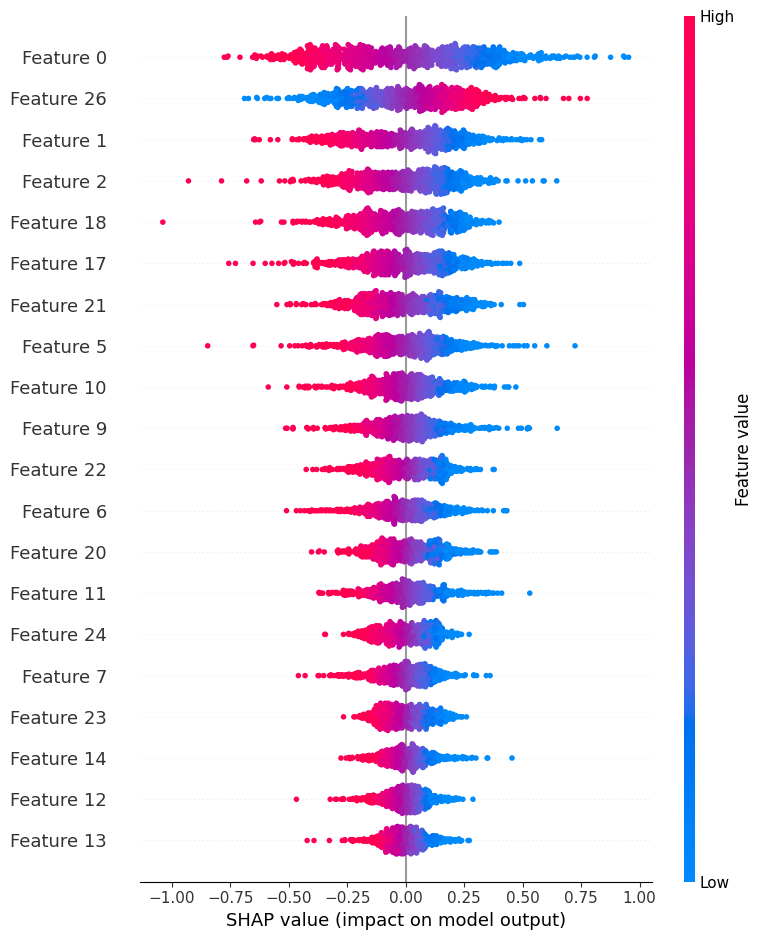

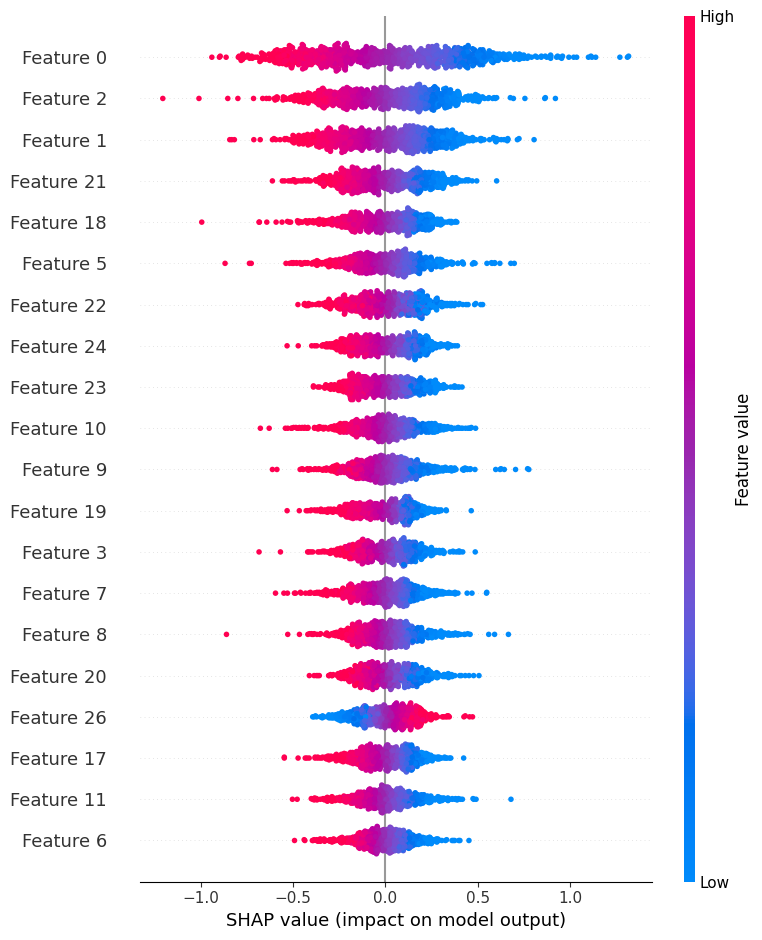

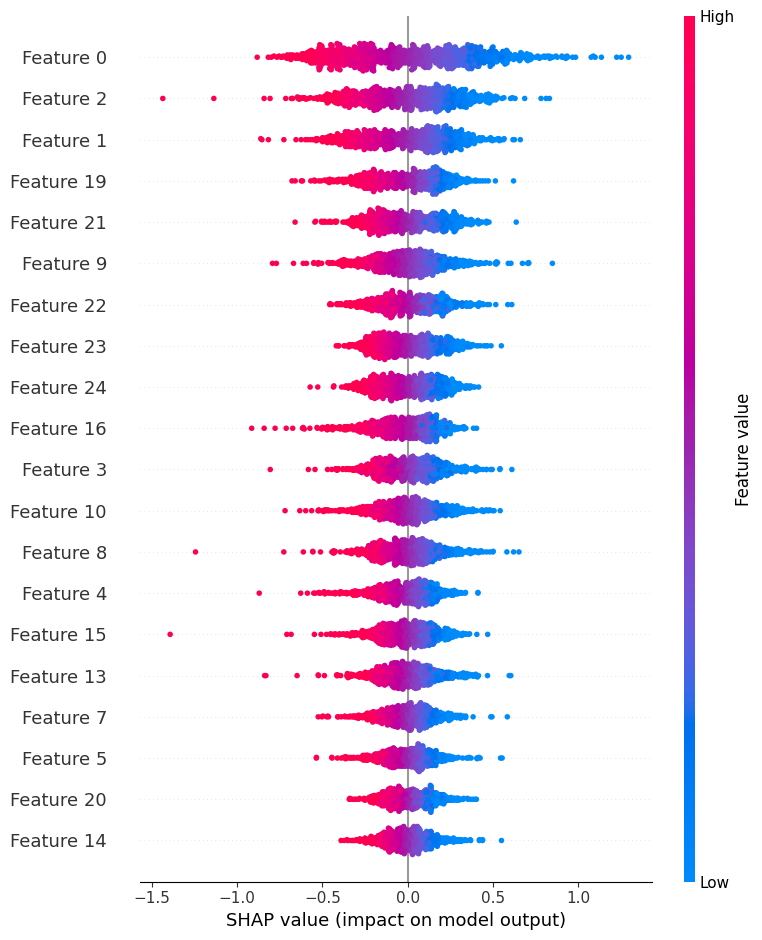

In [78]:
# Visualize SHAP values for each output
for i in range(shap_values.shape[2]):  # Loop over each output (3 in total)
    shap.summary_plot(shap_values=shap_values[:, :, i], features=X_test)